In [1]:
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import regex as re
import json
import nltk

%matplotlib inline

In [2]:
path_to_data = './data'

# create dataframe from sessions.json
df = pd.read_json(f'{path_to_data}/sessions_altered.json')
df.head()

# create dictionaries for switching between symptom and id
id2sym = {}
sym2id = {}

with open(f'{path_to_data}/symptoms.json') as json_file:
    data = json.load(json_file)
    for sym in data:
        id2sym[sym['id']] = sym['name']
        sym2id[sym['name']] = sym['id']
        
# add column with the symptom names
sym_names = []

for syms in df['confirmed']:
    if len(syms) != 0:
        sym_names.append([id2sym[x] for x in syms])
    else:
        sym_names.append([])

df['labels'] = sym_names

In [3]:
df.head()

,text,confirmed,suggested,labels
0,Slut på medicin.,"[89, 651]",[348],"[Känd astma, Känd lungsjukdom]"
1,Ångest,[],[118],[]
2,"Tänkte bara höra med Er, när jag har möjlighet...",[],"[89, 913]",[]
3,Behöver att prata med psykolog angående använd...,"[116, 215]","[215, 348, 446]","[Nedstämdhet, Trötthet]"
4,Har fått besvärlig eksem på händerna,"[2, 141]",[141],"[Hudbesvär, Synliga hudbesvär]"


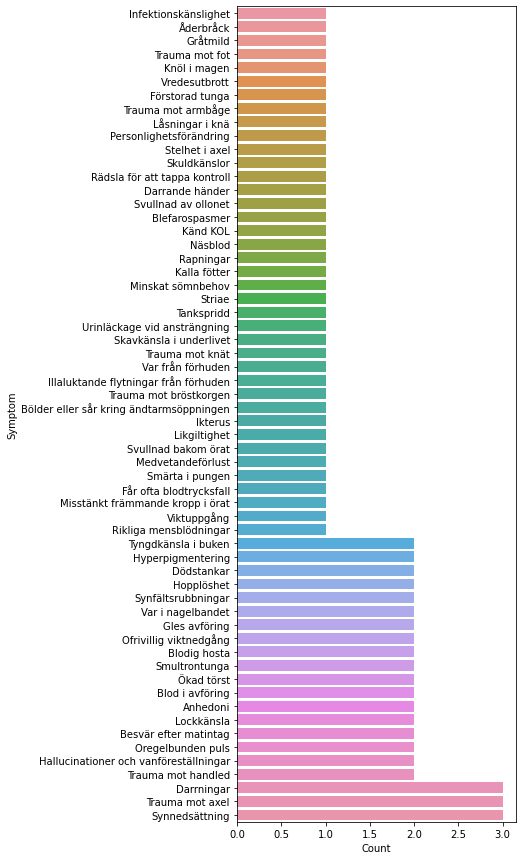

In [4]:
# plot the distribution of labels
all_syms = sum(sym_names,[])
all_syms = nltk.FreqDist(all_syms)

all_syms_df = pd.DataFrame({'Symptom': list(all_syms.keys()),
                            'Count': list(all_syms.values())
                           })

g = all_syms_df.nsmallest(columns='Count', n=60)
plt.figure(figsize=(5,15))
ax = sns.barplot(data=g, x='Count', y='Symptom')

2:	 29.31 %
0:	 18.83 %
1:	 32.09 %
3:	 12.44 %
4:	 4.41 %
5:	 1.68 %
6:	 0.60 %
7:	 0.41 %
10:	 0.02 %
8:	 0.11 %
16:	 0.02 %
11:	 0.02 %
9:	 0.06 %


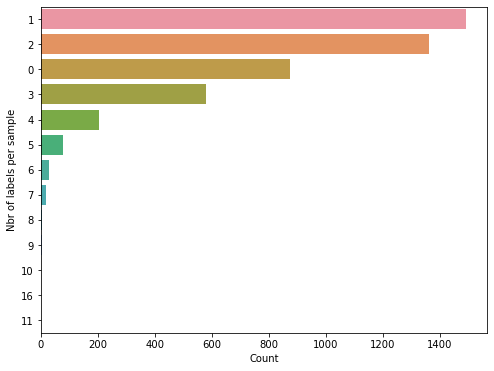

In [5]:
# plot the distribution of number of labels per sample
count_list = []

for sym_list in df['labels']:
    count_list.append(f'{len(sym_list)}')
    
count_dict = nltk.FreqDist(count_list)
count_dict_df = pd.DataFrame({'Nbr of labels per sample': list(count_dict.keys()),
                              'Count': list(count_dict.values())
                             })

# print percentages
count_dict_df = count_dict_df.sort_values(by=['Count'])
tot_samples = sum(count_dict_df['Count'].tolist())
for i in range(len(count_dict_df)):
    print(f'{count_dict_df["Nbr of labels per sample"][i]}:\t {count_dict_df["Count"][i] / tot_samples * 100:.2f} %')

g = count_dict_df.nlargest(columns='Count', n=60)

plt.figure(figsize=(8,6))
ax = sns.barplot(data=g, x='Count', y='Nbr of labels per sample')

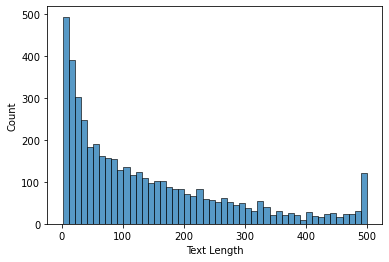

In [6]:
# plot the distribution of text lengths
length_list = []

for text in df['text']:
    length_list.append(len(text))

length_list_df = pd.DataFrame({'Text Length': length_list})

ax = sns.histplot(data=length_list_df, x='Text Length', bins=50)

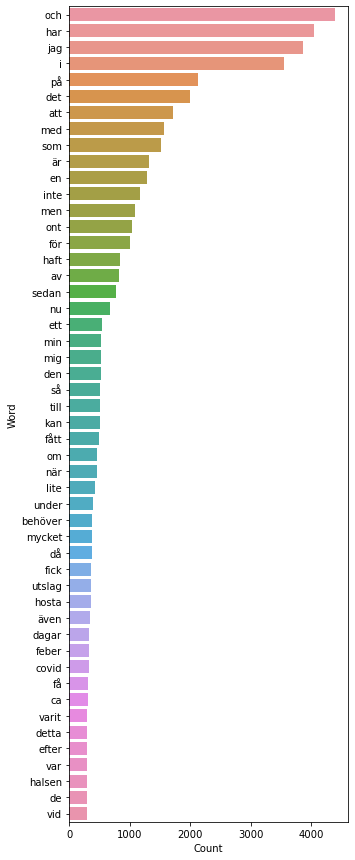

In [7]:
# plot the distribution of words
def clean_text(text):
    # turn text to lowercase
    text = text.lower()
    
    # remove all characters that are not letters or whitespace
    text = re.sub(r'[^\p{L} ]', '', text)
    
    return text

words = df['text'].tolist()
all_words = [clean_text(x).split() for x in words]
all_words = sum(all_words,[])
all_words = nltk.FreqDist(all_words)

all_words_df = pd.DataFrame({'Word': list(all_words.keys()),
                            'Count': list(all_words.values())
                           })

g = all_words_df.nlargest(columns='Count', n=50)
plt.figure(figsize=(5,15))
ax = sns.barplot(data=g, x='Count', y='Word')

In [8]:
# further explore the distribution of labels
labels = df['labels'].tolist()

multilab_bin = MultiLabelBinarizer()
y = multilab_bin.fit_transform(labels)

label_counts = np.sum(y, axis=0)
label_counts = np.flip(np.sort(label_counts))
print('Number of occurrences per label:')
print(label_counts)

n = 100
accum_per = np.sum([label_counts[:n]]) / np.sum(label_counts) * 100
print(f'The {n} most common labels make up {accum_per:.2f} % of all label occurrences')

m = 5
below_m = label_counts[label_counts < m]
print(f'{len(below_m)}/{len(label_counts)} labels have less than {m} occurrences')

Number of occurrences per label:
[1134  967  506  381  310  287  236  220  200  183  160  159  145  120
  114  103  100   93   73   68   64   61   55   52   52   50   48   48
   47   44   43   41   37   37   36   35   35   34   33   33   32   31
   29   28   28   28   28   27   25   25   23   22   21   21   20   20
   19   19   19   18   18   18   16   16   15   15   14   14   14   12
   12   12   11   11   11   10   10    9    9    9    9    9    8    8
    8    8    8    8    8    8    8    7    7    7    7    7    6    6
    6    6    6    6    6    6    6    5    5    5    5    5    5    5
    5    5    5    5    4    4    4    4    4    4    4    4    4    3
    3    3    3    3    3    3    3    3    3    3    3    3    3    3
    2    2    2    2    2    2    2    2    2    2    2    2    2    2
    2    2    2    2    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    